# **Gene Expression Heatplot**
This notebook generates a heat plot representing sex-biased differential gene expression as well as a plot showing the counts of differentially expressed genes per tissue.

The values in the heatmap represent the correlation (similarity in the fold-changes) between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.

The assumptions made before rendering the heatmaps 
1. Get differential gene expression (DGE) files
2. Use the ``../assets/tissues.tsv`` to limit the tissues to those with at least 50 samples in each sex (``tissues.tsv`` was produced by a Python script)
3. Use the pattern for the differentially expressed genes **"../data/*DGE.csv"** to get all the values for the matrix.

## **Running this notebook**:

See the README for setting up prerequisites for the notebook.

## 1. Setup 

Assumes the `countGenesAndEvents.ipynb` notebook was run -- unpacking the results from the differential Gene Expression Analysis as run in the `differentialGeneExpressionAnalysis.ipynb` notebook.

In [73]:
defaultW <- getOption("warn")  # suppress warnings for this cell
options(warn = -1) 

library(stringr)
library(edgeR)
library(pheatmap)
library(magrittr)
library(dplyr)
library(ggplot2)
library(scales)
library(viridis)
library(scales)

Sys.setenv(TAR = "/bin/tar") # for gzfile

options(warn = defaultW)

## 2. Making the matrices

### 2.1 Read in all the differential Gene Expression Analysis results

In [74]:
filenames <- list.files("data", pattern="*_DGE.csv", all.files=FALSE, full.names=TRUE)
message("Number of DGE files found with *_DGE.csv pattern: ",length(filenames))

Number of DGE files found with *_DGE.csv pattern: 39



### 2.2 read in the curated "../assets/tissues.tsv" 

The **`../assets/tissues.tsv`** file contains an indication to include the tissue if the file has at least **50** samples in that tissue with either **male** or **female** sex reporting

In [75]:
head(filenames)
# read in all requirements so that the stage is properly set -- 
# if it is clear here -- it will remain clear for the rest of the time
# tissues.tsv contains the subset of files desired for analysis.
tissue_reduction <- read.table(file="assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))
# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

message("Number of tissues with >=50 samples each in assets/tissues.tsv (tissue_reduction)",
        paste(dim(tissue_reduction), collapse=" "))

[1] "data/adipose_subcutaneous_DGE.csv"    
[2] "data/adipose_visceral_omentum_DGE.csv"
[3] "data/adrenal_gland_DGE.csv"           
[4] "data/artery_aorta_DGE.csv"            
[5] "data/artery_coronary_DGE.csv"         
[6] "data/artery_tibial_DGE.csv"


 0  1 
11 39 

Number of tissues with >=50 samples each in assets/tissues.tsv (tissue_reduction)39 5



### 2.3 model rownames from first file for the matrices

Arbitrarily using the first file, to obtain the ordered rownames for assignment to the remainder of the files in the construction of the matrix.

In [76]:
fullfilename <-filenames[1]
logFC_mat    <- read.csv(fullfilename)
pVal_mat     <- logFC_mat
logFC_mat    <- logFC_mat[order(rownames(logFC_mat)),]
logFC_mat_rownames <- as.character(rownames(logFC_mat)) 
pVal_mat_rownames  <- logFC_mat_rownames
pVal_mat     <- logFC_mat

In [77]:
head(logFC_mat)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,0.156530490,5.602619,3.7959250,1.605512e-04,1.189525e-03,-0.2420114
ENSG00000000005.5,0.225431430,4.050032,2.4823098,1.329945e-02,4.029577e-02,-4.1670662
ENSG00000000419.12,-0.018232130,4.694335,-0.9196733,3.580773e-01,4.959556e-01,-6.8746223
ENSG00000000457.13,0.006208543,3.933589,0.3014927,7.631332e-01,8.421680e-01,-7.1469088
ENSG00000000460.16,-0.039675603,2.252284,-1.3205613,1.871025e-01,3.065826e-01,-5.9973228
ENSG00000000938.12,0.368711533,5.227065,5.1061530,4.300071e-07,1.011877e-05,5.4106475


### 2.4 function make_tissue_matrix_ready for the logFC values

This function makes a logFC matrix for each of the tissues from the **`tissue_DGE.tsv`** results. One for each of our **`tissues`** of interest.

In [78]:
all.genes<-rownames(readRDS(file = "data/gtex.corrected.rds"))
fc.exp.mat<-matrix(rep(0), length(all.genes)*length(filenames),nrow = length(all.genes),ncol=length(filenames))

for (filename in filenames)
{
    next.res       <- read.csv(filename)
    
    next.res <- next.res[order(match(rownames(next.res),all.genes)),]
    
    fc.exp.mat[which(all.genes %in% rownames(next.res)),which(filenames==filename)]<-next.res$logFC
}

colnames(fc.exp.mat) <- gsub('data/','',gsub('_DGE.csv','',filenames))

label.tab<-read.csv('assets/tissues.tsv',header=TRUE,sep='\t')

label.tab<-label.tab[label.tab$name %in% colnames(fc.exp.mat),]

colnames(fc.exp.mat)<-label.tab$display.name[order(match(label.tab$display.name,colnames(fc.exp.mat)))]



In [79]:
tissue_list  <- levels(factor(tissue_reduction$SMTSD))
message("Number of tissues with at least 50 samples for both sexes: ",length(tissue_list))

Number of tissues with at least 50 samples for both sexes: 39



### 2.8 Reduce the matrix to only those that pass FC > 1.5 and <= adjusted pVal < 0.05

Remove the cells in the matrix that are <= abs(log2(1.5)) preserving only the values that are FC >= 1.5 and adj.P.Val <= 0.05 (from a separate but coordinated matrix.

### 2.9 Calculate the correlation between the tissues using the logFC and render the heatmaps of the distance correlations

Calculate the correlation distances between the tissues using the logFC within each of the tissues.   Clustering by similar expression.

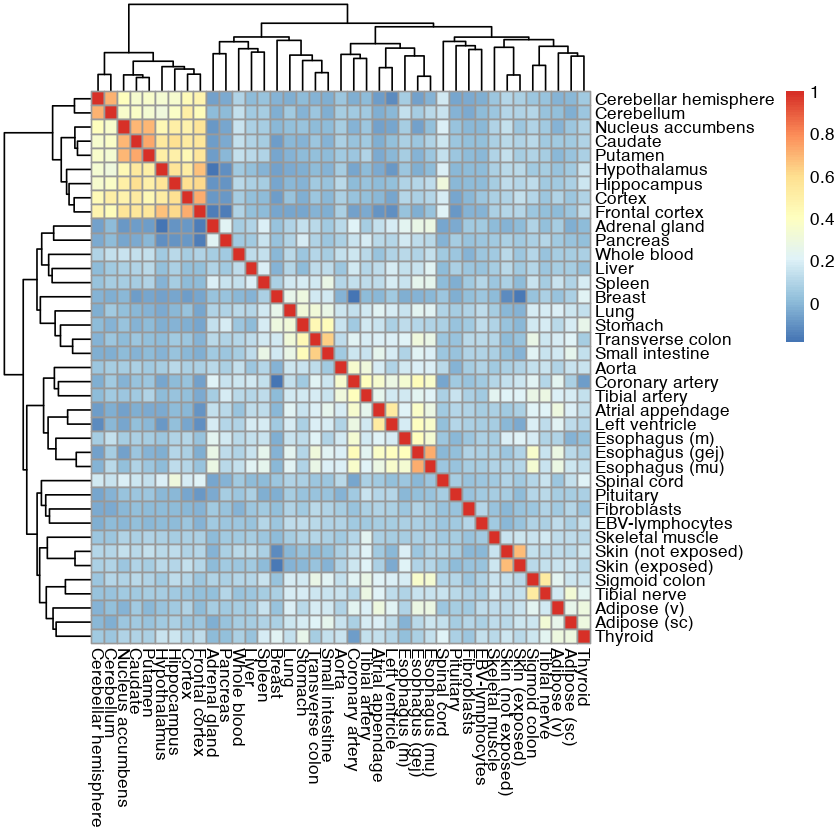

In [83]:
# dist_mat all values logFC_mat

fc.exp.mat<-fc.exp.mat[rowSums(fc.exp.mat!=0)>0,]
dist_mat <- as.matrix(cor(fc.exp.mat))
pheatmap(dist_mat)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="pdf/geneExpressionDistanceCorrelationHeatmapAlllogFC.pdf"))

## Appendix Metadata

For replicability and reproducibility purposes, we also print the following metadata:

### Appendix.1. Checksums with the sha256 algorithm
1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [81]:
figure_id   = "expressionHeatmap"

### Appendix.2. Libraries

In [82]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..

Warning message in gzfile(file, mode):
“cannot open compressed file '../metadata/expressionHeatmap_devtools_session_info.rds', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, mode): cannot open the connection
